In [2]:
# Remove Future Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# General
import numpy as np

# Data Management
import pandas as pd
from sklearn.model_selection import train_test_split

# Machine Learning
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

# Evaluation
from sklearn.metrics import precision_score

# Reporting
import matplotlib.pyplot as plt

# vectorbt
import vectorbtpro as vbt
vbt.settings.set_theme('dark')
vbt.settings['plotting']['layout']['width'] = 600
vbt.settings['plotting']['layout']['height'] = 300

In [3]:
df = pd.read_csv('2ySOLdata1h.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
df.set_index('timestamp', inplace=True)

pd.set_option('future.no_silent_downcasting', True)
df['signal'] = df['signal'].replace({'SignalNone': 1, 'SignalLong': 2, 'SignalShort': 0})
cols = list(df.columns)
cols.insert(0, cols.pop(cols.index('signal')))
df = df.loc[:, cols]
df = df.ffill()


In [4]:
data = vbt.Data.from_data(df)
features = data.run("talib", mavp=vbt.run_arg_dict(periods=14))
data.data['symbol'] = pd.concat([data.data['symbol'], features], axis=1)
data.data['symbol'].drop(['Open', 'High', 'Low', ('cosh', 'real'), ('exp', 'real'), ('sinh', 'real')], axis=1, inplace=True)

# This will drop columns from the DataFrame where all values are NaN
data.data['symbol'] = data.data['symbol'].dropna(axis=1, how='all')

open_price = data.get('Open')
high_price = data.get('High')
low_price = data.get('Low')
close_price = data.get('Close')

data.data['symbol'] = data.data['symbol'].dropna()

df_tts = data.copy()

# df_tts.data['symbol']

# df_tts.data['symbol'].drop(columns=["Close"], inplace=True)
# df_tts.data['symbol'].drop(columns=["Volume"], inplace=True)

df_tts.data['symbol'] = df_tts.data['symbol'].rename(columns={'signal': 'TARGET'})

# predictor_list = data.data['symbol'].drop('TARGET', axis=1).columns.tolist()
predictor_list = data.data['symbol'].iloc[:, 1:].columns.tolist()

X = df_tts.data['symbol'][predictor_list]
y = df_tts.data['symbol']['TARGET']

X.columns = X.columns.astype(str)

In [5]:
# Perform Train Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
# Select type of model to optimize for
is_binary = False
is_optimise_for_precision = True

In [7]:
# Determine Objective and Eval Metrics
if is_binary:
    objective = "binary:logistic"
    eval_metric = "logloss"
    eval_metric_list = ["error", "logloss", eval_metric]
else:
    objective = "multi:softmax"
    eval_metric = "mlogloss"
    eval_metric_list = ["merror", "mlogloss", eval_metric]

In [8]:
# Refine Eval Metric
if is_binary and is_optimise_for_precision:
    eval_metric = "aucpr"
    scoring = "precision"
elif is_binary and not is_optimise_for_precision:
    eval_metric = "auc"
    scoring = "f1"
else:
    scoring = "accuracy"

In [9]:
# Provide Gris for Hyperparams
param_grid = {
    "gamma": [0, 0.1, 0.2, 0.5, 1, 1.5, 2, 3, 6, 12, 20],
    "learning_rate": [0.01, 0.02, 0.03, 0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 0.8],
    "max_depth": [1, 2, 3, 4, 5, 6, 8, 12],
    "n_estimators": [25, 50, 65, 80, 100, 115, 200]
}

In [10]:
y_train = y_train.astype(float)

In [11]:
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)

X_train.fillna(-999, inplace=True)  # Or use an imputer

In [12]:
# Build First Classifier Model 0
classifier_0 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False,
    missing=-999
)

In [13]:
# Perform Random Search for Best Hyper params
grid_search = RandomizedSearchCV(estimator=classifier_0, param_distributions=param_grid, scoring=scoring)
best_model = grid_search.fit(X_train, y_train)
hyperparams = best_model.best_params_
ne = hyperparams["n_estimators"]
lr = hyperparams["learning_rate"]
md = hyperparams["max_depth"]
gm = hyperparams["gamma"]
print("Recommended Params >>", f"ne: {ne},", f"lr: {lr}", f"md: {md}", f"gm: {gm}")

Recommended Params >> ne: 80, lr: 0.03 md: 3 gm: 3


In [14]:
# Build Classification Model 1
classifier_1 = XGBClassifier(
    objective=objective,
    booster="gbtree",
    eval_metric=eval_metric,
    n_estimators=ne,
    learning_rate=lr,
    max_depth=md,
    gamma=gm,
    subsample=0.8,
    colsample_bytree=1,
    random_state=1,
    use_label_encoder=False
)

In [15]:
# Fit Model
eval_set = [(X_train, y_train)]
classifier_1.fit(
    X_train,
    y_train,
    eval_set=eval_set,
    verbose=False
)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None, colsample_bytree=1,
              device=None, early_stopping_rounds=None, enable_categorical=False,
              eval_metric='mlogloss', feature_types=None, gamma=3,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.03, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=80, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [16]:
# Get predictions for training data
train_yhat = classifier_1.predict(X_train)
print("Training Preds: \n", train_yhat[:5])

Training Preds: 
 [1 1 1 1 1]


In [17]:
# Set K-Fold Cross Validation Levels
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [18]:
# Training Results
train_results = cross_val_score(classifier_1, X_train, y_train, scoring=scoring, cv=cv, n_jobs=1)

In [19]:
# Brief Review of Training Results

# print("Average Accuracy K-Fold: ", round(train_results.mean(), 2))
# print("Std Deviation K-Fold: ", round(train_results.std(), 2))
# print("Precision Score 0: ", round(precision_score(y_train, train_yhat, average=None)[0], 3))
# print("Precision Score 1: ", round(precision_score(y_train, train_yhat, average=None)[1], 3))

# print("")
# print("Just for reference. Right now, we are only focussed on getting some initial features.")
# print("If the results look too good to be true, they probably are.")

### Feature Selection

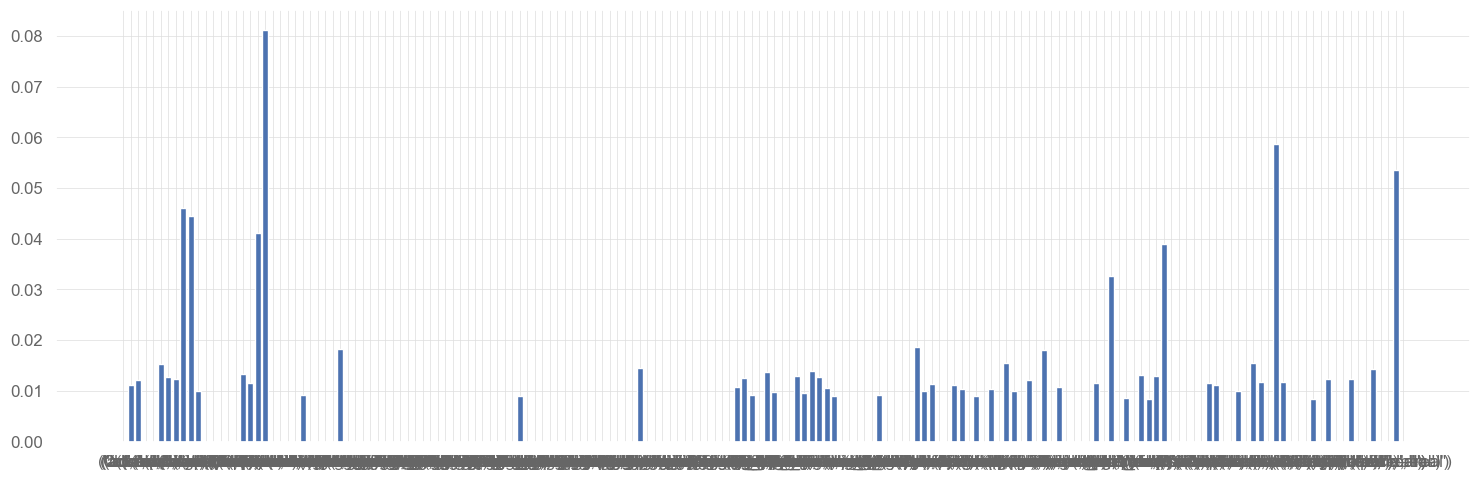

In [20]:
# Plot Feature Importances
fig = plt.figure(figsize=(15, 5))
importance_labels = X.columns
importance_features = classifier_1.feature_importances_
plt.bar(importance_labels, importance_features)
plt.tight_layout()  # Adjust layout to fit
plt.show()

In [27]:
# Select Best Features
mean_feature_importance = importance_features.mean()*3
i = 0
recommended_feature_labels = []
recommended_feature_score = []
for fi in importance_features:
    if fi > mean_feature_importance:
        recommended_feature_labels.append(importance_labels[i])
        recommended_feature_score.append(fi)
    i += 1

In [30]:
print(recommended_feature_labels)

["('aroon', 'aroondown')", "('aroon', 'aroonup')", "('bop', 'real')", "('cci', 'real')", "('cdlbelthold', 'integer')", "('macd', 'macd')", "('midprice', 'real')", "('mom', 'real')", "('roc', 'real')", "('stochrsi', 'fastk')", "('willr', 'real')"]


In [31]:
import ast

# Convert string representations of tuples into actual tuples
tuple_list = [ast.literal_eval(item) for item in recommended_feature_labels]

print(tuple_list)

[('aroon', 'aroondown'), ('aroon', 'aroonup'), ('bop', 'real'), ('cci', 'real'), ('cdlbelthold', 'integer'), ('macd', 'macd'), ('midprice', 'real'), ('mom', 'real'), ('roc', 'real'), ('stochrsi', 'fastk'), ('willr', 'real')]


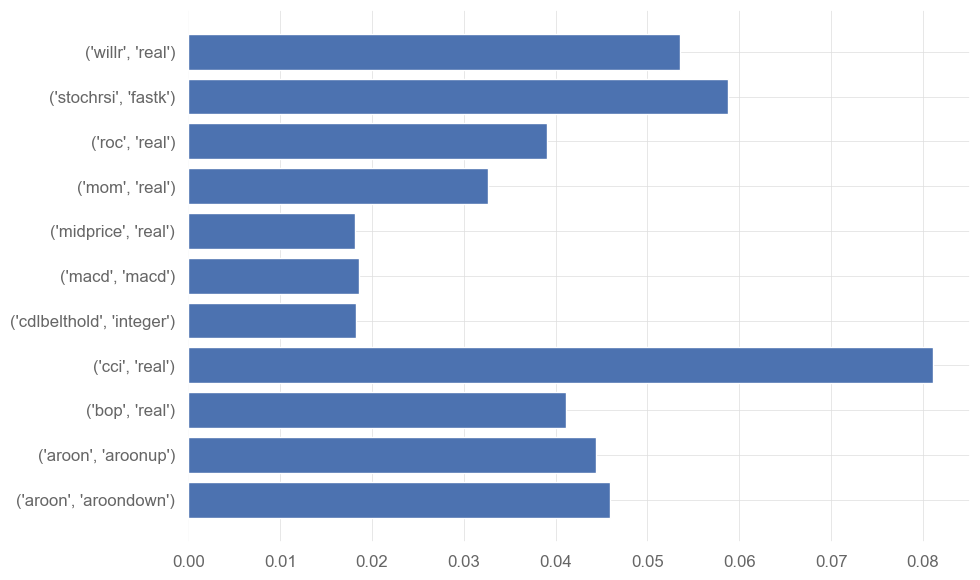

In [32]:
# Plot Recommended Features
fig = plt.figure(figsize=(10, 6))
plt.barh(recommended_feature_labels, recommended_feature_score)
plt.tight_layout()  # Adjust layout to fit
plt.show()
